**IEA Wind TCP Task 55: The IEA Wind 740-10-MW Reference Offshore Wind Plants**

<https://www.osti.gov/biblio/2333634/>

This notebook uses `interarray` to route the collector system cables for the two wind power plants presented in the report above.

This example requires an additional package:

`pip install pyyaml-include`

In [1]:
from pathlib import Path
import numpy as np
import yaml
import yaml_include

In [2]:
from interarray.interarraylib import L_from_site, G_from_S
from interarray.svg import svgplot
from interarray.mesh import make_planar_embedding
from interarray.pathfinding import PathFinder
from interarray.interface import assign_cables
import interarray.MILP.ortools as ort
from interarray.baselines.hgs import iterative_hgs_cvrp

## Load layouts from files

In [3]:
# Wind farms stored according to the windIO format
# https://windio.readthedocs.io/en/latest/

yaml.add_constructor(
    "!include", yaml_include.Constructor(base_dir='data'))

def load_windIO(filepath):
    fpath = Path(filepath)
    with open(fpath, 'r') as f:
        system = yaml.full_load(f)
    coords = (system['wind_farm']['layouts']['initial_layout']
              ['coordinates'])
    terminalC = np.c_[coords['x'], coords['y']]
    coords = system['wind_farm']['electrical_substations']['coordinates']
    rootC = np.c_[coords['x'], coords['y']]
    coords = system['site']['boundaries']['polygons'][0]
    borderC = np.c_[coords['x'], coords['y']]
    T = terminalC.shape[0]
    R = rootC.shape[0]
    name_tokens = fpath.stem.split('_')
    return L_from_site(
        R=R, T=T,
        VertexC=np.vstack((terminalC, borderC, rootC)),
        border=np.arange(T, T + borderC.shape[0]),
        name=' '.join(name_tokens),
        handle=(f'{name_tokens[0].lower()}_'
                f'{name_tokens[1][:4].lower()}_'
                f'{name_tokens[2][:3].lower()}'),
    )

In [4]:
L_reg = load_windIO('data/IEA37_Borssele_Regular_System.yaml')

In [5]:
L_irr = load_windIO('data/IEA37_Borssele_Irregular_System.yaml')

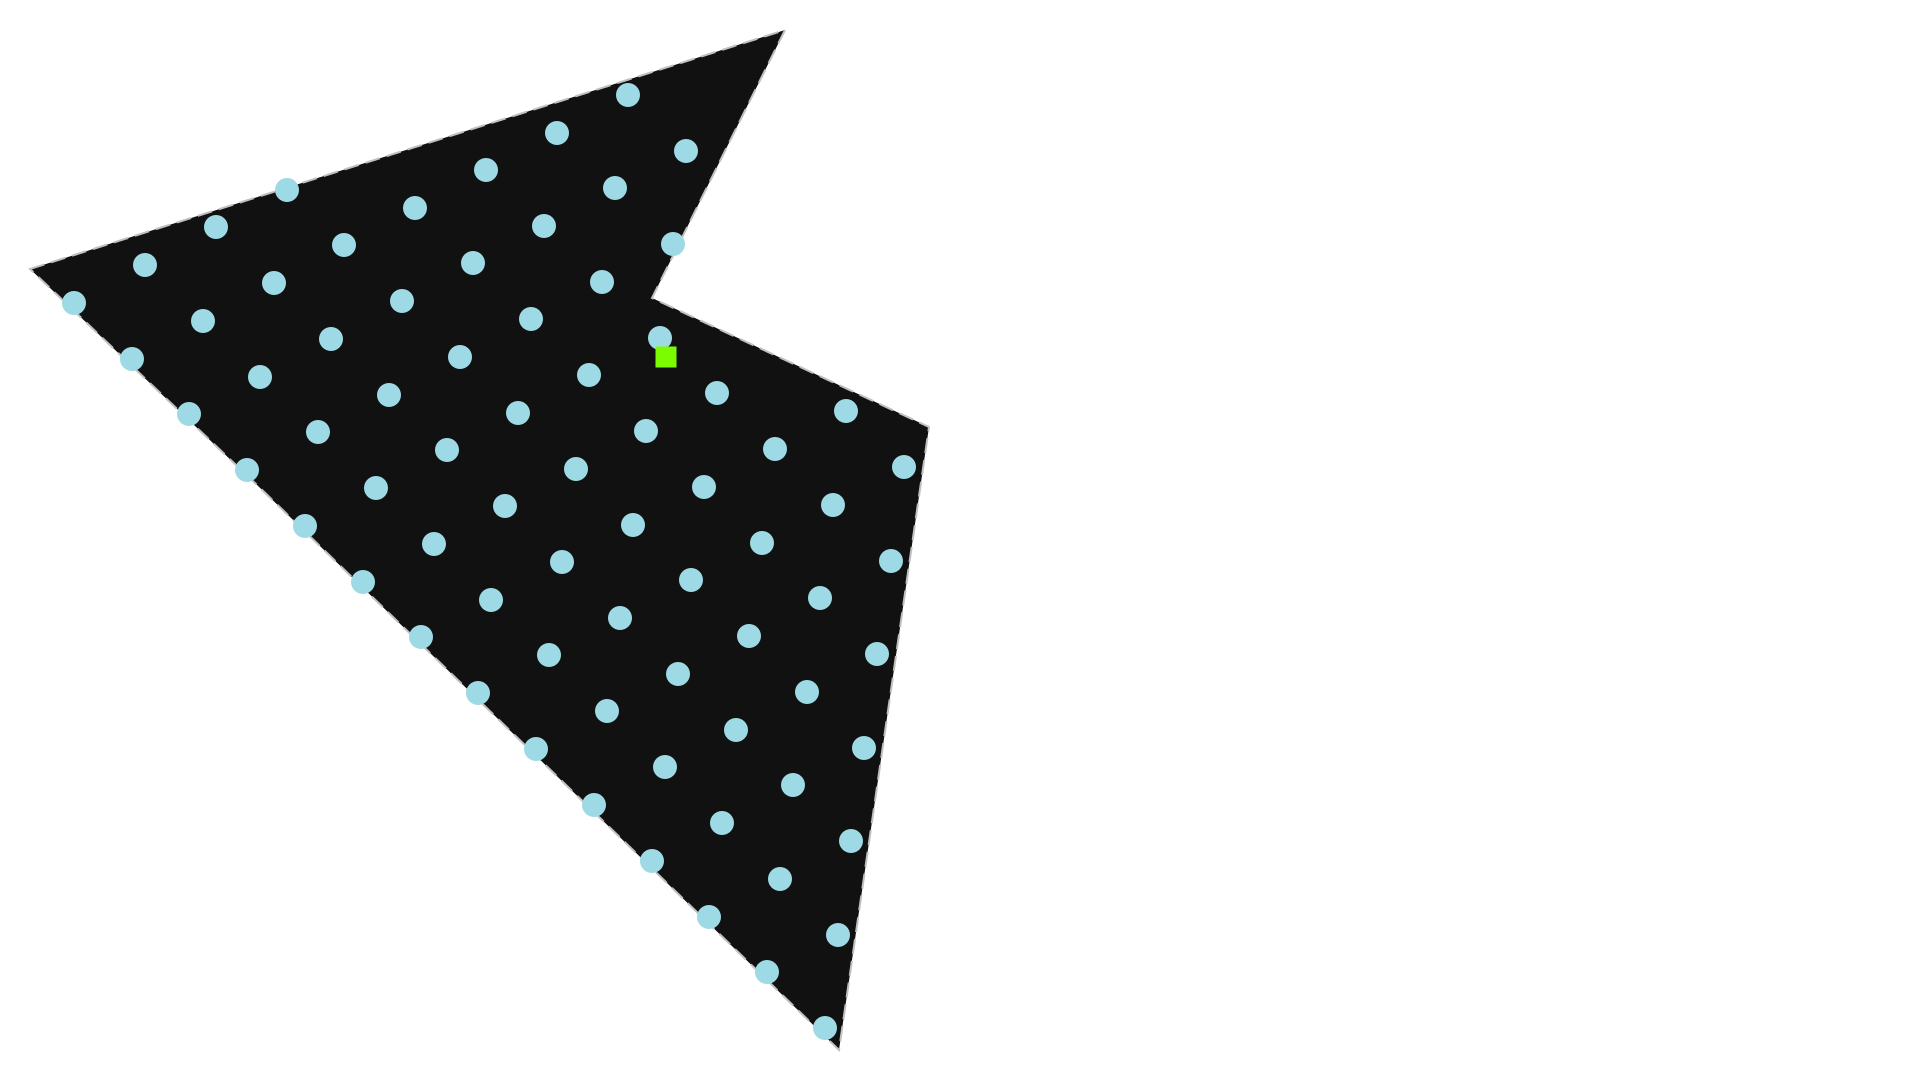

In [6]:
svgplot(L_reg)

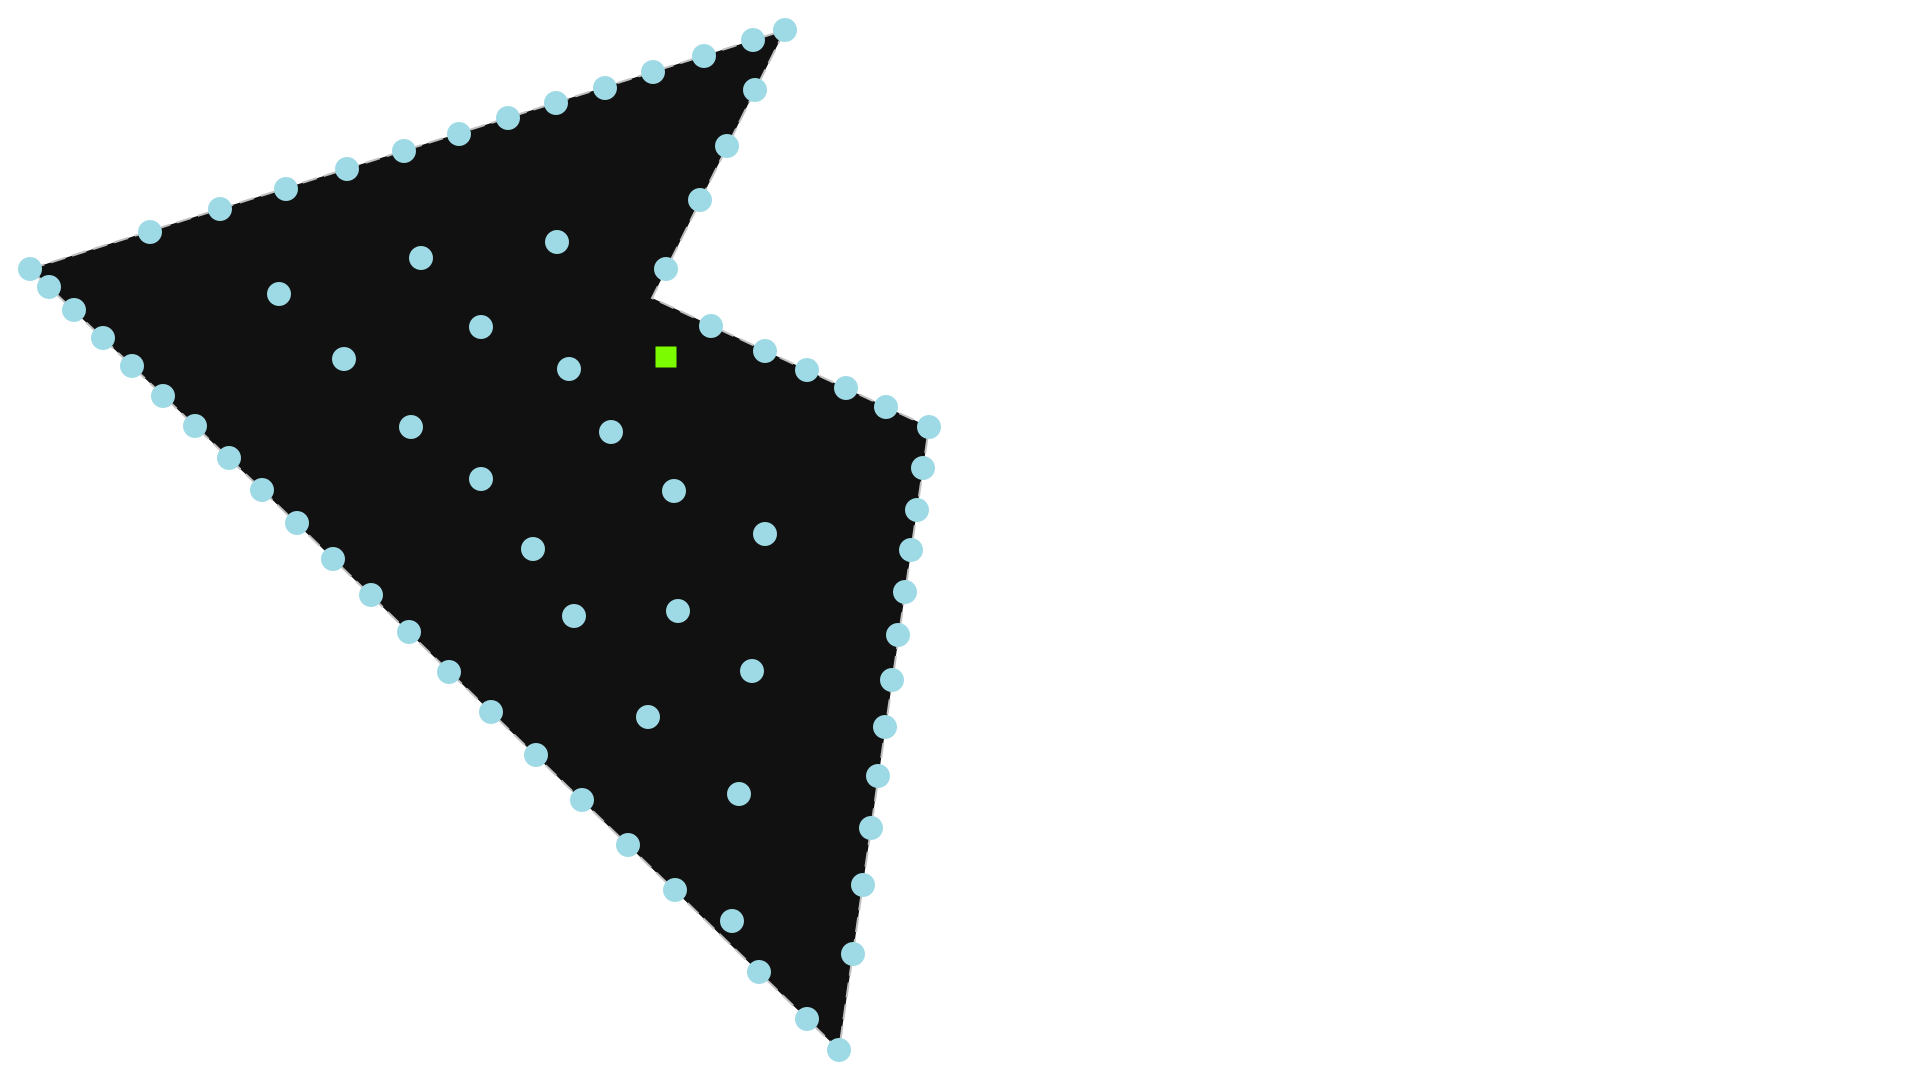

In [7]:
svgplot(L_irr)

## Additional design parameters

In [8]:
cable_costs = [206, 287, 406]  # [€/m] Costs per distance for each cable type
turbines_per_cable = [3, 5, 7]

In [9]:
cables = [(None, capacity, cost) for capacity, cost in zip(turbines_per_cable, cable_costs)]
capacity = max(turbines_per_cable)

## Choose solver

In [10]:
solver = ort.cp_model.CpSolver()

## Regular layout

In [11]:
P, A = make_planar_embedding(L_reg)

In [12]:
# This meta-heuristic call is iterative and the time_limit applies
# to each iteration. About 97% of instances use a single iteration.
S_warm = iterative_hgs_cvrp(A, capacity=capacity, time_limit=3)

Check the total length of the warm-start solution:

In [13]:
G_reg_warm = G_from_S(S_warm, A)
G_reg_warm.size(weight='length')

139656.4789599965

In [14]:
model = ort.make_min_length_model(
    A, capacity,
    gateXings_constraint=False,
    branching=True,
    gates_limit=False
)
ort.warmup_model(model, S_warm);

In [15]:
solver.parameters.max_time_in_seconds = 300
solver.parameters.relative_gap_limit = 0.005
solver.parameters.num_workers = 8

# be verbose
solver.parameters.log_search_progress = True
# required to get the log inside the notebook (goes only to console otherwise)
solver.log_callback = print

result = solver.solve(model)

gap = 1 - solver.BestObjectiveBound()/solver.ObjectiveValue()
print('=================================================================',
      #solver.ResponseStats(),  # uncomment if solver.parameters.log_search_progress == False
      f"\nbest solution's strategy: {solver.SolutionInfo()}",
      f'\ngap: {100*gap:.1f}%')


Starting CP-SAT solver v9.11.4210
Parameters: max_time_in_seconds: 300 log_search_progress: true relative_gap_limit: 0.005 num_workers: 8

Initial optimization model 'IEA37 Borssele Regular System': (model_fingerprint: 0xfc481b5049527471)
#Variables: 1'540 (#bools: 422 in floating point objective)
  - 1'118 Booleans in [0,1]
  - 348 in [-6,6]
  - 74 in [0,7]
#kAtMostOne: 341 (#literals: 1'385)
#kLinear1: 2'236 (#enforced: 2'236)
#kLinearN: 77 (#terms: 1'340)

Starting presolve at 0.01s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 422 terms with magnitude in [440.736, 14559.3] average = 3224.81
[Scaling] Objective coefficient relative error: 6.70633e-10
[Scaling] Objective worst-case absolute error: 4.25878e-05
[Scaling] Objective scaling factor: 1.04858e+06
  3.65e-04s  0.00e+00d  [DetectDominanceRelations] 
  1.14e-02s  0.00e+00d  [operations_research::sat::CpModelPresolver::PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  6.44e-0

In [16]:
S_solver = ort.S_from_solution(model, solver, result)
G_solver = G_from_S(S_solver, A)
G_reg = PathFinder(G_solver, planar=P, A=A).create_detours()

In [17]:
assign_cables(G_reg, cables)
G_reg.size(weight='cost')

40714260.58298516

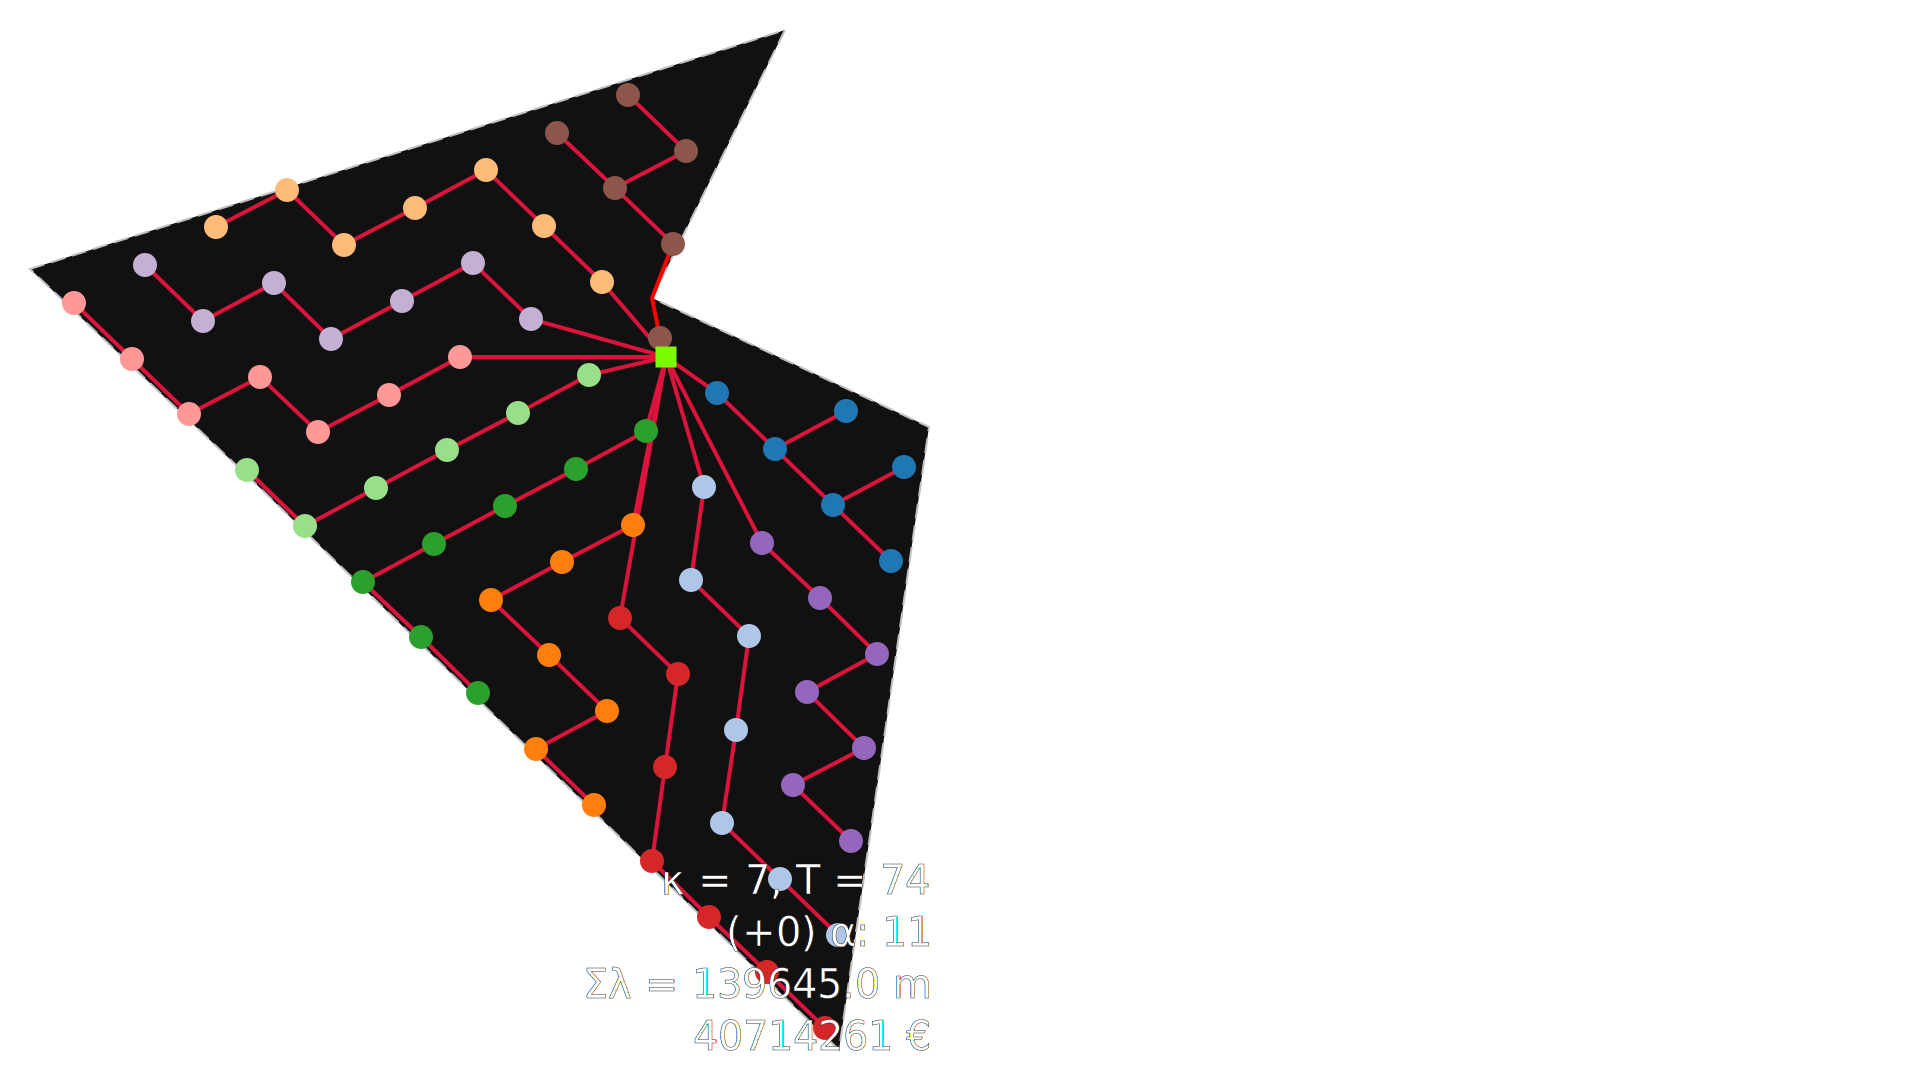

In [19]:
svgplot(G_reg)

## Irregular layout

In [20]:
P, A = make_planar_embedding(L_irr)

In [21]:
# This meta-heuristic call is iterative and the time_limit applies
# to each iteration. About 97% of instances use a single iteration.
S_warm = iterative_hgs_cvrp(A, capacity=capacity, time_limit=3)

Check the total length of the warm-start solution:

In [22]:
G_irr_warm = G_from_S(S_warm, A)
G_irr_warm.size(weight='length')

136451.2768186806

In [23]:
model = ort.make_min_length_model(
    A, capacity,
    gateXings_constraint=False,
    branching=True,
    gates_limit=False
)
ort.warmup_model(model, S_warm);

In [24]:
solver.parameters.max_time_in_seconds = 300
solver.parameters.relative_gap_limit = 0.005
solver.parameters.num_workers = 8

# be verbose
solver.parameters.log_search_progress = True
# required to get the log inside the notebook (goes only to console otherwise)
solver.log_callback = print

result = solver.solve(model)

gap = 1 - solver.BestObjectiveBound()/solver.ObjectiveValue()
print('=================================================================',
      #solver.ResponseStats(),  # uncomment if solver.parameters.log_search_progress == False
      f"\nbest solution's strategy: {solver.SolutionInfo()}",
      f'\ngap: {100*gap:.1f}%')


Starting CP-SAT solver v9.11.4210
Parameters: max_time_in_seconds: 300 log_search_progress: true relative_gap_limit: 0.005 num_workers: 8

Initial optimization model 'IEA37 Borssele Irregular System': (model_fingerprint: 0x1e7e6244d2b57ccd)
#Variables: 1'192 (#bools: 335 in floating point objective)
  - 857 Booleans in [0,1]
  - 261 in [-6,6]
  - 74 in [0,7]
#kAtMostOne: 232 (#literals: 943)
#kLinear1: 1'714 (#enforced: 1'714)
#kLinear3: 4
#kLinearN: 73 (#terms: 1'067)

Starting presolve at 0.00s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 335 terms with magnitude in [539.378, 15073.7] average = 3923
[Scaling] Objective coefficient relative error: 1.08619e-09
[Scaling] Objective worst-case absolute error: 7.7051e-05
[Scaling] Objective scaling factor: 524288
  3.14e-04s  0.00e+00d  [DetectDominanceRelations] 
  8.02e-03s  0.00e+00d  [operations_research::sat::CpModelPresolver::PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  5.79e

In [35]:
solver.parameters.max_time_in_seconds = 300
solver.parameters.relative_gap_limit = 0.005
solver.parameters.num_workers = 8

# be verbose
solver.parameters.log_search_progress = True
# required to get the log inside the notebook (goes only to console otherwise)
solver.log_callback = print

result = solver.solve(model)

gap = 1 - solver.BestObjectiveBound()/solver.ObjectiveValue()
print('=================================================================',
      #solver.ResponseStats(),  # uncomment if solver.parameters.log_search_progress == False
      f"\nbest solution's strategy: {solver.SolutionInfo()}",
      f'\ngap: {100*gap:.1f}%')


Starting CP-SAT solver v9.11.4210
Parameters: max_time_in_seconds: 300 log_search_progress: true relative_gap_limit: 0.005 num_workers: 8

Initial optimization model 'IEA37 Borssele Irregular System': (model_fingerprint: 0x1e7e6244d2b57ccd)
#Variables: 1'192 (#bools: 335 in floating point objective)
  - 857 Booleans in [0,1]
  - 261 in [-6,6]
  - 74 in [0,7]
#kAtMostOne: 232 (#literals: 943)
#kLinear1: 1'714 (#enforced: 1'714)
#kLinear3: 4
#kLinearN: 73 (#terms: 1'067)

Starting presolve at 0.00s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 335 terms with magnitude in [539.378, 15073.7] average = 3923
[Scaling] Objective coefficient relative error: 1.08619e-09
[Scaling] Objective worst-case absolute error: 7.7051e-05
[Scaling] Objective scaling factor: 524288
  2.96e-04s  0.00e+00d  [DetectDominanceRelations] 
  6.74e-03s  0.00e+00d  [operations_research::sat::CpModelPresolver::PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  3.55e

In [25]:
S_solver = ort.S_from_solution(model, solver, result)
G_solver = G_from_S(S_solver, A)
G_irr = PathFinder(G_solver, planar=P, A=A).create_detours()

In [26]:
assign_cables(G_irr, cables)
G_irr.size(weight='cost')

43091183.191651106

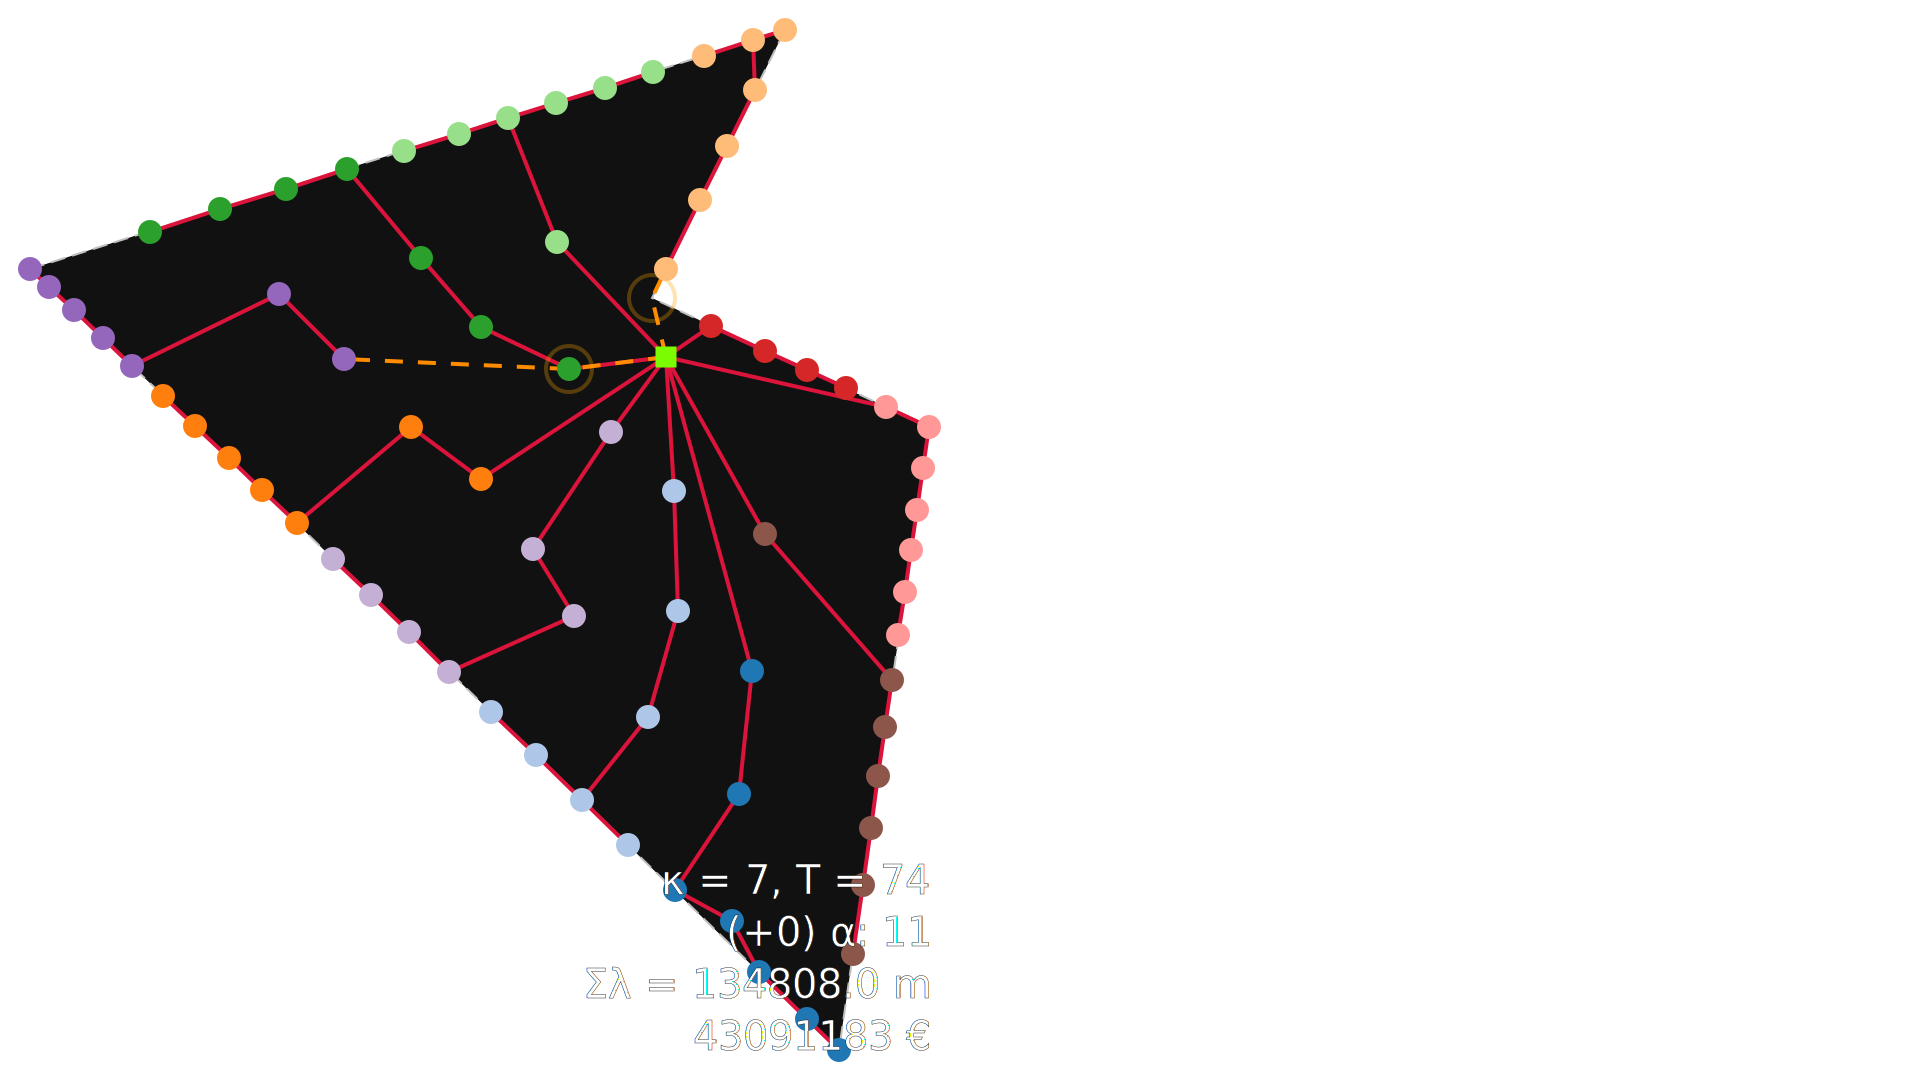

In [27]:
svgplot(G_irr)

## Layouts' edge list

These lists of 3-tuples has all the edges and their cable type (as an index to the `turbines_per_cable` list), i.e. (coordinate_A, coordinate_B, cable_type).

Negative node indices represent substations, the node indices ranging from 0 to 73 represent the WT in the order they were given.

If the layout has contours or detours, indices will go beyond the number of coordinates (WT, SS, borders) provided, and the mapping of these additional indices to indices to the provided coordinates is presented.

In [28]:
G_reg.edges(data='cable')

EdgeDataView([(-1, 47, 2), (-1, 56, 2), (-1, 46, 2), (-1, 33, 2), (-1, 45, 2), (-1, 57, 2), (-1, 34, 2), (-1, 24, 2), (-1, 49, 2), (-1, 58, 2), (-1, 32, 2), (45, 44, 1), (33, 23, 2), (34, 25, 2), (57, 67, 2), (46, 35, 2), (47, 48, 1), (24, 15, 2), (49, 50, 2), (32, 21, 2), (58, 59, 2), (56, 80, 1), (71, 66, 0), (71, 72, 0), (66, 65, 1), (66, 73, 0), (67, 68, 1), (68, 69, 1), (69, 61, 0), (44, 31, 0), (44, 43, 0), (65, 80, 1), (18, 19, 0), (19, 28, 0), (25, 26, 1), (26, 17, 1), (17, 16, 0), (31, 30, 0), (31, 42, 0), (23, 22, 1), (61, 70, 0), (70, 63, 0), (5, 4, 0), (5, 9, 1), (9, 15, 1), (4, 1, 0), (10, 11, 0), (11, 16, 0), (51, 62, 0), (51, 60, 1), (62, 53, 0), (60, 59, 1), (53, 64, 0), (3, 2, 0), (3, 8, 0), (8, 14, 0), (14, 22, 1), (29, 38, 0), (29, 40, 0), (41, 52, 0), (41, 54, 0), (52, 39, 1), (54, 55, 0), (39, 50, 1), (28, 27, 0), (6, 7, 0), (7, 12, 0), (35, 36, 1), (27, 36, 1), (48, 37, 1), (37, 38, 0), (12, 13, 0), (13, 20, 1), (20, 21, 1), (0, 1, 0)])

Mapping of contour/detour node to the index of its VertexC coordinate :

In [29]:
if G_reg.graph.get('C') or G_reg.graph.get('D'):
    R, T, B = (G_reg.graph[k] for k in 'RTB')
    print(dict(enumerate(
        (n.item() for n in G_reg.graph['fnT'][T + B:-R]),
        start=T + B
    )))

{80: 76}


In [30]:
G_irr.edges(data='cable')

EdgeDataView([(-1, 41, 2), (-1, 28, 2), (-1, 49, 2), (-1, 55, 1), (-1, 39, 2), (-1, 60, 2), (-1, 70, 2), (-1, 25, 2), (-1, 33, 2), (-1, 80, 2), (-1, 81, 2), (70, 67, 2), (41, 51, 2), (49, 54, 2), (71, 64, 2), (71, 81, 2), (28, 53, 2), (60, 59, 2), (55, 40, 0), (25, 42, 2), (73, 68, 2), (73, 80, 2), (39, 63, 2), (33, 45, 2), (15, 21, 0), (15, 3, 0), (21, 66, 0), (3, 12, 1), (58, 65, 0), (58, 61, 1), (65, 48, 0), (65, 47, 0), (61, 64, 1), (16, 29, 1), (16, 17, 0), (29, 53, 1), (17, 24, 0), (36, 62, 0), (36, 35, 0), (62, 69, 1), (35, 6, 0), (69, 63, 1), (42, 8, 1), (8, 2, 1), (37, 51, 1), (37, 20, 1), (20, 4, 0), (20, 34, 0), (67, 22, 1), (5, 9, 0), (5, 32, 0), (32, 14, 1), (9, 19, 0), (10, 24, 0), (40, 57, 0), (57, 72, 0), (1, 34, 0), (54, 30, 1), (46, 44, 0), (46, 50, 0), (50, 0, 0), (44, 22, 1), (23, 43, 0), (43, 7, 0), (7, 2, 0), (31, 26, 0), (31, 56, 0), (56, 30, 1), (26, 13, 0), (14, 68, 1), (27, 52, 0), (27, 38, 0), (52, 59, 0), (59, 18, 0), (12, 45, 1), (11, 18, 0)])

Mapping of contour/detour node to the index of its VertexC coordinate :

In [31]:
if G_irr.graph.get('C') or G_irr.graph.get('D'):
    R, T, B = (G_irr.graph[k] for k in 'RTB')
    print(dict(enumerate(
        (n.item() for n in G_irr.graph['fnT'][T + B:-R]),
        start=T + B
    )))

{80: 28, 81: 76}
